#### ex8 Collaborative filtering learning algorithm

You will implement the collaborative filtering learning algorithms. The collorative filtering algorithm in the setting of movie recommendation considers a set of n-dimensional parameter vectors x1,x2,...,x(nm) and theta1, theta2,...,theta(nu), where the model predicts the rating for movie i by user j. y(i,j)=thetaj.T*xi.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
from scipy.optimize import minimize
from scipy.io import loadmat

#### Part 1: Loading movie ratings dataset 

We load the movie ratings dataset to understand the structure of the data.

In [2]:
print('Loading movie ratings dataset.');

#  Load data
movie=loadmat('ex8_movies.mat');
print(movie.keys())
#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies on 943 users
# R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a 
# rating to movie i
Y=movie['Y']
R=movie['R']
print(Y.shape)
print(R.shape)

Loading movie ratings dataset.
dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])
(1682, 943)
(1682, 943)


In [3]:
#  From the matrix, we can compute statistics like average rating.
print('Average rating for movie 1 (Toy Story): ', np.mean(Y[0,R[0,:]==1]));

Average rating for movie 1 (Toy Story):  3.8783185840707963


Text(0.5,15,'Users')

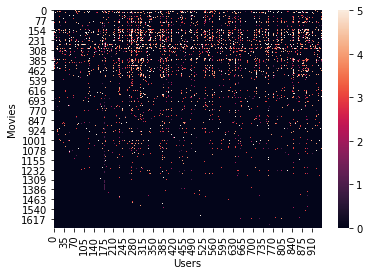

In [4]:
#  We can visualize the ratings matrix by plotting it with the seaborn heatmap
import seaborn as sns
sns.heatmap(Y)
plt.ylabel('Movies')
plt.xlabel('Users')

#### Part 2: Collaborative Filtering Cost Function
We will now implement the cost function for collaborative filtering.

In [5]:
# Load pre-trained weights (X, Theta, num_users, num_movies, num_features)
param=loadmat ('ex8_movieParams.mat');
X=param['X']
Theta=param['Theta']
num_users=param['num_users']
num_movies=param['num_movies']
num_features=param['num_features']
param.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Theta', 'num_users', 'num_movies', 'num_features'])

In [6]:
# Reduce the data set size so that this runs faster
num_users = 4; num_movies = 5; num_features = 3;
X = X[0:num_movies, 0:num_features];
Theta = Theta[0:num_users, 0:num_features];
Y = Y[0:num_movies, 0:num_users];
R = R[0:num_movies, 0:num_users];

##### 2.1 Collaborative filtering cost function

The collaborative filtering cost function(without regularization) is given by
<img src='../pic/RS_cost1.jpg'>

In [7]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lambda_var):

# Notes: X - num_movies  x num_features matrix of movie features
#        Theta - num_users  x num_features matrix of user features
#        Y - num_movies x num_users matrix of user ratings of movies
#        R - num_movies x num_users matrix, where R(i, j) = 1 if the i-th movie was rated by the j-th user

# Unfold the U and W matrices from params
    X = np.reshape(params[0:num_movies*num_features], (num_movies, num_features), order='F');
    Theta = np.reshape(params[num_movies*num_features::], (num_users, num_features), order='F');

    J = 0;
    X_grad = np.zeros(X.shape);
    Theta_grad = np.zeros(Theta.shape);
    
    squared_error=np.power(np.dot(X, Theta.T)-Y,2)
    J=0.5*np.sum(squared_error*R)+lambda_var/2*np.sum(np.power(params,2))
    X_grad=np.dot((np.dot(X, Theta.T)*R-Y), Theta)+lambda_var*X
    Theta_grad=np.dot((np.dot(X, Theta.T)*R-Y).T, X)+lambda_var*Theta
    
    grad = np.concatenate((X_grad.reshape(X_grad.size,order='F'), Theta_grad.reshape(Theta_grad.size, order='F')))
    return J, grad

In [8]:
#  Evaluate cost function
params = np.concatenate((X.reshape(X.size, order='F'), Theta.reshape(Theta.size, order='F')))

J, grad= cofiCostFunc(params, Y, R, num_users, num_movies, num_features, 0)
           
print('Cost at loaded parameters:', J)
print('this value should be about 22.22')

Cost at loaded parameters: 22.224603725685675
this value should be about 22.22


#### Part 3: Collaborative Filtering Gradient 

Once your cost function matches up with ours, you should now implement 
the collaborative filtering gradient function. Specifically, you should 
complete the code in cofiCostFunc.m to return the grad argument.

In [9]:
def computeNumericalGradient(J, theta):

    numgrad = np.zeros(theta.shape);
    perturb = np.zeros(theta.shape);
    
    e = 1e-4;
    
    for p in range(theta.size):
    # Set perturbation vector
        perturb.reshape(perturb.size, order='F')[p]=e
        loss1,_ = J(theta - perturb);
        loss2,_ = J(theta + perturb);
    # Compute Numerical Gradient
        numgrad.reshape(numgrad.size, order='F')[p] = (loss2 - loss1) / (2*e);
        perturb.reshape(perturb.size, order='F')[p] = 0;
    return numgrad

In [10]:
def checkCostFunction(lambda_var):
    
#   CHECKCOSTFUNCTION(lambda) Creates a collaborative filering problem 
#   to check your cost function and gradients, it will output the 
#   analytical gradients produced by your code and the numerical gradients 
#   (computed using computeNumericalGradient). These two gradient 
#   computations should result in very similar values.

# Set lambda
    if not lambda_var:
        lambda_var=0

# Create small problem
    X_t = np.random.rand(4, 3);
    Theta_t = np.random.rand(5, 3);

# Zap out most entries
    Y = np.dot(X_t,Theta_t.T);
    Y[np.random.rand(Y.shape[0], Y.shape[1]) > 0.5] = 0
    R = np.zeros(Y.shape);
    R[Y!=0] = 1;

# Run Gradient Checking
    X = np.random.randn(X_t.shape[0], X_t.shape[1]);
    Theta = np.random.randn(Theta_t.shape[0], Theta_t.shape[1]);
    num_users = Y.shape[1];
    num_movies = Y.shape[0];
    num_features = Theta_t.shape[1];
    params = np.concatenate((X.reshape(X.size, order='F'), Theta.reshape(Theta.size, order='F')))

    def costFunc(p):
        return cofiCostFunc(p,  Y, R, num_users, num_movies, num_features, lambda_var);
    
    numgrad = computeNumericalGradient(costFunc, params);
    cost, grad =cofiCostFunc(params,  Y, R, num_users, num_movies, num_features, lambda_var); 
    print(numgrad.shape)
    print(grad.shape)
    print(np.column_stack((numgrad,grad)))

    diff = np.linalg.norm(numgrad-grad)/np.linalg.norm(numgrad+grad);
    print('The relative difference is :', diff);

In [11]:
 print('\nChecking Gradients (without regularization) ... \n')

#  Check gradients by running checkNNGradients
checkCostFunction(lambda_var=0)


Checking Gradients (without regularization) ... 

(27,)
(27,)
[[-0.4113512  -0.4113512 ]
 [ 6.77091772  6.77091772]
 [ 0.92829249  0.92829249]
 [-0.05255745 -0.05255745]
 [ 0.41727341  0.41727341]
 [-1.43520019 -1.43520019]
 [ 0.40996355  0.40996355]
 [-0.15919567 -0.15919567]
 [ 0.69834781  0.69834781]
 [-1.0361805  -1.0361805 ]
 [ 0.35918003  0.35918003]
 [-0.25335212 -0.25335212]
 [-2.54099153 -2.54099153]
 [ 0.82136919  0.82136919]
 [-0.1874529  -0.1874529 ]
 [-4.49609827 -4.49609827]
 [-0.63495674 -0.63495674]
 [ 1.94587412  1.94587412]
 [-0.47009049 -0.47009049]
 [ 0.34649008  0.34649008]
 [ 4.70375829  4.70375829]
 [ 0.54813348  0.54813348]
 [-0.60706196 -0.60706196]
 [-0.05907787 -0.05907787]
 [-0.6323278  -0.6323278 ]
 [-0.70693072 -0.70693072]
 [ 0.30871194  0.30871194]]
The relative difference is : 1.4934351453163246e-12


#### Part 4: Collaborative Filtering Cost Regularization 

Now we will implement regularization for the cost function for collaborative filtering. We can implement it by adding the cost of regularization to the original cost computation.

In [15]:
params = np.concatenate((X.reshape(X.size, order='F'), Theta.reshape(Theta.size, order='F')))
#  Evaluate cost function
J, grad = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, 1.5);
            
print('Cost at loaded parameters (lambda=1.5) is {:f}:'.format(J))     
print('this value should be about 31.34')

Cost at loaded parameters (lambda=1.5) is 31.344056:
this value should be about 31.34


#### Part 5: Entering ratings for a new user

Before we will train the collaborative filtering model, we will first add ratings that correspond to a new user that we just observed. This part of the code will also allow us to put in your own ratings for the movies in our dataset!

In [19]:
def loadMovieList():
    ## Read the fixed movieulary list
    with open("movie_ids.txt") as movie_ids_file:

        n = 349  # Total number of movies 
        movieList = [None]*n
        for i, line in enumerate(movie_ids_file.readlines()):
            #print(line)
            movieName = line.split()
            #print(movieName)
            movieList[i] = " ".join(movieName)
    #print(movieList)
    return movieList

In [20]:
movieList = loadMovieList();
print(movieList[0:2])
movieList

['1 Toy Story (1995)', '2 GoldenEye (1995)']


['1 Toy Story (1995)',
 '2 GoldenEye (1995)',
 '3 Four Rooms (1995)',
 '4 Get Shorty (1995)',
 '5 Copycat (1995)',
 '6 Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 '7 Twelve Monkeys (1995)',
 '8 Babe (1995)',
 '9 Dead Man Walking (1995)',
 '10 Richard III (1995)',
 '11 Seven (Se7en) (1995)',
 '12 Usual Suspects, The (1995)',
 '13 Mighty Aphrodite (1995)',
 '14 Postino, Il (1994)',
 "15 Mr. Holland's Opus (1995)",
 '16 French Twist (Gazon maudit) (1995)',
 '17 From Dusk Till Dawn (1996)',
 '18 White Balloon, The (1995)',
 "19 Antonia's Line (1995)",
 '20 Angels and Insects (1995)',
 '21 Muppet Treasure Island (1996)',
 '22 Braveheart (1995)',
 '23 Taxi Driver (1976)',
 '24 Rumble in the Bronx (1995)',
 '25 Birdcage, The (1996)',
 '26 Brothers McMullen, The (1995)',
 '27 Bad Boys (1995)',
 '28 Apollo 13 (1995)',
 '29 Batman Forever (1995)',
 '30 Belle de jour (1967)',
 '31 Crimson Tide (1995)',
 '32 Crumb (1994)',
 '33 Desperado (1995)',
 '34 Doom Generation, The (1995)',
 '35

In [21]:
#  Initialize my ratings
my_ratings = np.zeros((349,1));

# Check the file movie_idx.txt for id of each movie in our dataset
# For example, Toy Story (1995) has ID 1, so to rate it "4", you can set
my_ratings[0] = 4;

# Or suppose did not enjoy Silence of the Lambs (1991), you can set
my_ratings[98] = 2;

# We have selected a few movies we liked / did not like and the ratings we
# gave are as follows:
my_ratings[6] = 3;
my_ratings[11]= 5;
my_ratings[53] = 4;
my_ratings[63]= 5;
my_ratings[65]= 3;
my_ratings[68] = 5;
my_ratings[182] = 4;
my_ratings[225] = 5;
my_ratings[339]= 5;

In [22]:
my_ratings[340]

array([0.])

In [23]:
print('\n\nNew user ratings:\n');

for i in range(len(my_ratings)):
    if my_ratings[i] > 0: 
        print(my_ratings[i],movieList[i]);



New user ratings:

[4.] 1 Toy Story (1995)
[3.] 7 Twelve Monkeys (1995)
[5.] 12 Usual Suspects, The (1995)
[4.] 54 Outbreak (1995)
[5.] 64 Shawshank Redemption, The (1994)
[3.] 66 While You Were Sleeping (1995)
[5.] 69 Forrest Gump (1994)
[2.] 99 Snow White and the Seven Dwarfs (1937)
[4.] 183 Alien (1979)
[5.] 226 Die Hard 2 (1990)
[5.] 340 Boogie Nights (1997)


#### Part 6: Learning Movie Ratings 

Now, we will train the collaborative filtering model on a movie rating dataset of 349 movies and 943 users

In [24]:
ex8_movies=loadmat('ex8_movies.mat');

#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies by 943 users
#  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a rating to movie i
Y=ex8_movies['Y']
R=ex8_movies['R']
print(Y.shape)
print(R.shape)
Y_sub=Y.copy()
Y_sub=Y_sub[:349,:]
R_sub=R.copy()
R_sub=R_sub[:349,:]

(1682, 943)
(1682, 943)


In [28]:
#  Add our own ratings to the data matrix
Y_sub=np.column_stack((my_ratings,Y_sub))
R_sub = np.column_stack(((my_ratings!=0).astype(int),R_sub))

In [29]:
print(R_sub.shape)
print(Y_sub.shape)

(349, 944)
(349, 944)


In [31]:
def normalizeRatings(Y, R):
    # [Ynorm, Ymean] = NORMALIZERATINGS(Y, R) normalized Y so that each movie
    # has a rating of 0 on average, and returns the mean rating in Ymean.
    m, n = Y.shape
    Ymean = np.zeros((m, 1))
    Ynorm = np.zeros(Y.shape)
    for i in range(m):
        idx = R[i, :] == 1 #idx is for columns that have ratings 
        Ymean[i] = np.mean(Y[i, idx])
        Ynorm[i, idx] = Y[i, idx] - Ymean[i]

    return Ynorm, Ymean

In [32]:
#  Normalize Ratings
[Ynorm, Ymean] = normalizeRatings(Y_sub, R_sub);

In [33]:
#  Useful Values
num_users = Y_sub.shape[1];
num_movies = Y_sub.shape[0];
num_features = 10;

# Set Initial Parameters (Theta, X)
X = np.random.randn(num_movies, num_features);
Theta = np.random.randn(num_users, num_features);

In [34]:
initial_parameters = np.concatenate((X.reshape(X.size, order='F'), Theta.reshape(Theta.size, order='F')))

# Set options
maxiter = 100
options = {'disp': True, 'maxiter':maxiter}
lambda_var=10

# Create "short hand" for the cost function to be minimized
def costFunc(initial_parameters):
    return cofiCostFunc(initial_parameters, Y_sub, R_sub, num_users, num_movies, num_features, lambda_var)

# Set Regularization
results = minimize(costFunc, x0=initial_parameters, options=options, method="L-BFGS-B", jac=True)
theta = results["x"]

# Unfold the returned theta back into U and W
X = np.reshape(theta[:num_movies*num_features], (num_movies, num_features), order='F')
Theta = np.reshape(theta[num_movies*num_features:], (num_users, num_features), order='F')

#### Part 7: Recommendation for you

After training the model, you can now make recommendations by computing the predictions matrix.

In [35]:
p = np.dot(X, Theta.T)
my_predictions = p[:,0] + Ymean.flatten()

In [105]:
ix = my_predictions.argsort()[::-1]

print('\n\nTop recommendations for you:\n')
for i in range(10):
    j = ix[i]
    print('Predicting rating {:.5f} for movie {:s}'.format(my_predictions[j], movieList[j]))

print('\n\nOriginal ratings provided:')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated {:d} for {:s}'.format(int(my_ratings[i]), movieList[i]))



Top recommendations for you:

Predicting rating 8.95425 for movie 313 Titanic (1997)
Predicting rating 8.88282 for movie 64 Shawshank Redemption, The (1994)
Predicting rating 8.73734 for movie 272 Good Will Hunting (1997)
Predicting rating 8.72771 for movie 318 Schindler's List (1993)
Predicting rating 8.63722 for movie 127 Godfather, The (1972)
Predicting rating 8.61210 for movie 12 Usual Suspects, The (1995)
Predicting rating 8.57416 for movie 50 Star Wars (1977)
Predicting rating 8.45038 for movie 98 Silence of the Lambs, The (1991)
Predicting rating 8.44930 for movie 302 L.A. Confidential (1997)
Predicting rating 8.39593 for movie 22 Braveheart (1995)


Original ratings provided:
Rated 4 for 1 Toy Story (1995)
Rated 3 for 7 Twelve Monkeys (1995)
Rated 5 for 12 Usual Suspects, The (1995)
Rated 4 for 54 Outbreak (1995)
Rated 5 for 64 Shawshank Redemption, The (1994)
Rated 3 for 66 While You Were Sleeping (1995)
Rated 5 for 69 Forrest Gump (1994)
Rated 2 for 99 Snow White and the Se